<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

<div class="alert alert-info">
  <strong>Info!</strong> Привет! Тут небольшая вводная информация по моему проекту. Этот проект ужасно требовательный по ресурсам, поэтому выборка была значительно уменьшена. Ввиду того, что выборка была уменьшена - несбалансированность по классам невилировалась. Тем не менее, ансамблиевые модели упорно не считались, не говоря уже о нейросетях)
</div>

<font color='blue' size=5><b>Комментарий ревьюера</b></font>

<font color='blue'>Привет, Людмила! Меня зовут Павел Григорьев, и я буду проверять этот проект.<br>Моя основная цель - не указать на совершённые тобой ошибки, а поделиться своим опытом и помочь тебе совершенствоваться как профессионалу.<br>Спасибо за проделанную работу! Предлагаю общаться на «ты».</font>
<details>
	<summary><u>Инструкция по организационным моментам (кликабельно)</u></summary>
<font color='blue'>Я буду использовать различные цвета, чтобы было удобнее воспринимать мои комментарии:</font>


---


<font color='blue'>синий текст - просто текст комментария</font>

<font color='green'>✔️ и зеленый текст - все отлично</font>

<font color='orange'>⚠️ и оранжевый текст - сделано все правильно, однако есть рекомендации, на что стоит обратить внимание</font>

<font color='red'>❌ и красный текст - есть недочеты</font>


</details>    
    </br>
<font color='blue'>Пожалуйста, не удаляй мои комментарии в случае возврата работы, так будет проще разобраться, какие были недочеты, а также сразу увидеть исправленное. </font>

Ответы на мои комментарии лучше тоже помечать.
Например: <font color='purple'><b>Комментарий студента</b></font>

<font color='blue'><b>Давай смотреть, что получилось!</b></font>


# Проект для «Викишоп»

**Исходные данные:**
Данных с разметкой о токсичности правок. В файле `toxic_comments.csv` находятся столбец *text*, содержащий текст комментария, а *toxic* — целевой признак.


**Цель:**
Построить модель, которая будет искать токсичные комментарии и отправлять их на модерацию. Обучить модель классифицировать комментарии на позитивные и негативные, со значением метрики качества *F1* не меньше 0.75. 



**Этапы исследования:**


1.  Загрузка исходных данных и их общая оценка
2.  Подготовка данных для последующей работы
4.  Обучение различных моделей
5.  Заключение, подведение итогов работы.



In [51]:
# !pip install --upgrade matplotlib --quiet install
# !pip install seaborn --upgrade --quiet install
# !pip install transformers --quiet install
# !pip install python-dateutil --quiet install
# !pip install imblearn --quiet install
# %pip install spacy --quiet install

In [52]:

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
import spacy
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.linear_model import LogisticRegression, SGDClassifier

RANDOM_STATE = 42

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Хорошее оформление импортов! \
Импорты собраны в одной ячейке, разделены на функциональные группы пустой строкой.</font>

In [53]:
class ShowData:
    '''

    there are the methods for help to look thought the data
    "download_data" open dataset(download) from collab and from other paths,
    "change_data" replaces name of columns according to PEP8 and convert 
    to lower data type,
    "general_info" provides with the numbers of columns/rows, type of columns 
    and occupied memory,
    "deep_info" provides with statistic info and info for preprocessing step,
    "hist_box" shows histograms and boxplots for each numeric column 
    (DON'T FORGET TO CHANGE THE GRAPH SIZE),
    "cor_matrix" shows correlation matrix for all numeric columns, 
    it uses Pearson coefficient

    '''
    def download_data(self, path):

        import os
        if os.path.exists(path):
            df = pd.read_csv(path)
        elif os.path.exist(path):
            from google.colab import drive
            drive.mount('/content/drive')
            df = pd.read_csv(path)
        else:
            print("The path doesn't exist")

        return df

    def change_data(self, df):

        df.columns = (df.columns
                        .str.replace('(?<=[a-z])(?=[A-Z])|(\s)', '_', 
                                     regex=True).str.lower())
        try:
            for name in df.select_dtypes("number").columns:
                df[name] = pd.to_numeric(df[name], downcast="float"
                                        if (df[name] // 1 == 0).all()
                                        else "integer")
        except:
            pass
        return df

    def general_info(self, df):

        info_0 = pd.DataFrame(df.dtypes.value_counts(), columns=[""])
        info_0.loc["columns", ""] = len(df.columns)
        info_0.loc["row", ""] = len(df)
        info_0.loc["memory_usage, MB", ""] = df.memory_usage()\
        .sum() / (1024 ** 2)

        return info_0

    def deep_info(self, df):

        info_1 = pd.DataFrame(index=df.columns, columns=['rows'], data=len(df))
        info_1["null_row"] = (df == 0).sum(axis=0)
        info_1["uniq"] = df.nunique()
        info_1["dup_val"] = [df[i].duplicated().sum() for i in df]
        info_1["dup_row"] = df.duplicated().sum()
        info_1["NaN"] = df.isna().sum()
        info_1["NaN,%"] = df.isna().mean()
        info_1["type"] = df.dtypes
        info_1 = info_1.join(df.describe(include="number")["mean":].transpose())
        info_1.fillna("", inplace=True)
        for col in info_1.loc[:, "mean":]:
            info_1[col] = pd.to_numeric(info_1[col], downcast="float")
        info_1["null_row"] = pd.to_numeric(info_1["null_row"], 
                                           downcast="integer")
        info_1["outliers"] = info_1["max"] > info_1["75%"] \
                             + 1.5 * (info_1["75%"] - info_1["25%"])

        prop = {
            "border": "0.5px solid black",
            "width": "85px",
            "text-align": "center"
        }
        percent = {
            "NaN,%":"{:.3%}",
            "mean":"{:.3}",
            "std":"{:.3}",
            "min":"{:.3}",
            "25%":"{:.3}",
            "50%":"{:.3}",
            "75%":"{:.3}",
            "max":"{:.3}",
        }

        return info_1, info_1.style.format(percent).set_properties(**prop)

    def hist_box(self, df, size):

        df_num = df.select_dtypes("number")
        fig = plt.figure(figsize=size)
        sfigs = fig.subfigures(round(size[0]), 4)
        for i, axes in enumerate(sfigs.flat):
            try:
                axes.suptitle(df_num.columns[i])
                if len(df.iloc[:,i]) > 0:
                    ax_1= axes.subplots(2, 1, sharex=True,
                                        gridspec_kw={
                                            "height_ratios": (.15, .85)
                                            }
                                        )
                    sns.boxplot(data=df, x=df_num.columns[i], orient="h",
                                ax=ax_1[0])
                    sns.histplot(data=df, x=df_num.columns[i], kde=True,
                                 ax=ax_1[1])
                    plt.xlabel("")
                    plt.ylabel("")
            except:
                break
        plt.show()

    def cor_matrix(self, df):

        length = len(df.columns)
        plt.figure(figsize=(length/1.5, length/1.5))
        sns.heatmap(df.corr(method="pearson"), annot=True, linewidths=0.3,
            cmap="coolwarm", square=True)
        plt.show()

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Очистка сделана верно! Мы оставили только символы Латинского алфавита нижнего регистра.</font> 

In [54]:
# create a variable for class
sd = ShowData()
# download data
data = sd.download_data("toxic_comments.csv")
# show first 5 rows
data.head()

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at N...",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of m...",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents...",0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


<font color='blue'><b>Комментарий ревьюера: </b></font> ❌\
<font color='red'>Ошибка исполнения кода. Данные должны загружаться у тех кому проект предоставляется.</font>

In [55]:
pd.set_option("max_colwidth", 160)
# invert the data columns to snake case
data = sd.change_data(data)
# look through the general info about data
sd.general_info(data)

,
int32,1.000000
object,1.000000
int8,1.000000
columns,3.000000
row,159292.000000
"memory_usage, MB",1.974987


In [56]:
info = sd.deep_info(data)[0]
info

,rows,null_row,uniq,dup_val,dup_row,NaN,"NaN,%",type,mean,std,min,25%,50%,75%,max,outliers
unnamed:_0,159292,1,159292,0,0,0,0.0,int32,79725.697242,46028.837471,0.0,39872.75,79721.5,119573.25,159450.0,False
text,159292,0,159292,0,0,0,0.0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
toxic,159292,143106,2,159290,0,0,0.0,int8,0.101612,0.302139,0.0,0.00,0.0,0.00,1.0,True


In [57]:
data[data.index != data["unnamed:_0"]]

,unnamed:_0,text,toxic
6080,6084,"""::I'll alos be looking in to see how this is going, as GRC is a big deal around these parts. Seek his grace \n\n""",0
6081,6085,"""\n\nThe Ezekiel passage is quoted in the Moloch article in the 1899 Encyclopædidia Biblica as the strongest evidence for the theory that the offerings were...",0
6082,6086,"Thank you for experimenting with Wikipedia. Your test worked, and it has been reverted or removed. Please use the sandbox for any other tests you may want ...",0
6083,6087,Any complaints with that as the new wording?,0
6084,6088,"""\nI also disagree with the merge as Strength athlete clearly refers to strong sportspeople in general rather than anything to do with competitions or feats...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You c...",0
159288,159447,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61.19.93,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0
159290,159449,And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.,0


In [58]:
data.drop("unnamed:_0", axis=1, inplace=True)

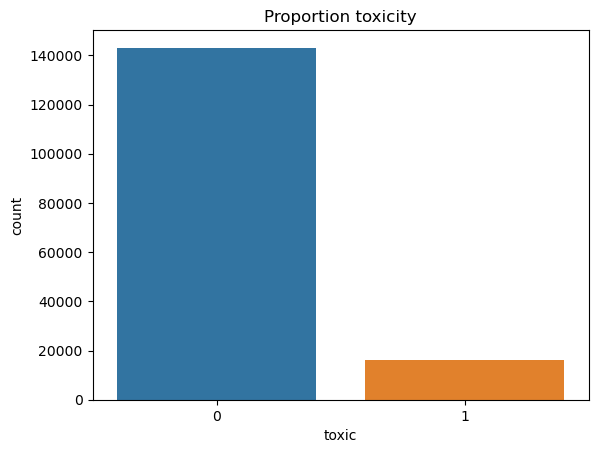

In [59]:
sns.countplot(x = 'toxic', data = data)
plt.title("Proportion toxicity")
plt.show()


<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Мы обнаружили серьёзный дисбаланс при исследовании данных. Как дополнительные материалы, рекомендую статью <a href='https://dyakonov.org/2021/05/27/imbalance/'>Дисбаланс классов</a>, очень классная, как и весь блог Дьяконова. Ещё такой <a href='https://github.com/Dyakonov/ml_hacks/blob/master/book_disbalance_public_v1.ipynb'>ноутбук</a> есть.</font>

На основе проведенного анализа данных можно сделать следующие выводы:

Набор данных содержит информацию о комментариях и метки о наличии токсичности.
Из общей информации видно, что набор данных состоит из 159571 строк и 7 столбцов, и занимает около 10 мегабайт памяти.
Анализ подробной информации о данных позволил выявить наличие насбалансированности по классам в данных.

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Данные загружены корректно, первичный осмотр проведен.</font>

## Подготовка

In [60]:
data.toxic.value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

<font color='blue'><b>Комментарий ревьюера: </b></font> ❌\
<font color='red'> Мы не можем балансировать весь датасет, поскольку в этом случае мы балансируем также тестовую выборку. С такой тестовой выборкой метрика не сможет адекватно оценить работу модели на входящих данных с реальным распределением таргетов. </font>

In [61]:
def clean_text(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = re.sub("http\S+", " ", text)
    text = re.sub("\s{2,}", " ", text)
    return text
def tokenize_text(text):
    return re.split("\W+", text)
def remove_words(text):
    stop_words = nltk.corpus.stopwords.words("english")
    return [word for word in text if word not in stop_words]


In [62]:
data["text"] = data["text"].apply(clean_text).apply(tokenize_text)

In [63]:
#lemmatization
lemma = nltk.WordNetLemmatizer()

data["text"] = data["text"].apply(
    lambda x: " ".join([lemma.lemmatize(word) for word in x])
    )

In [64]:
lemmatizer = WordNetLemmatizer()


def lemmatize_with_pos(text):
    tagged_tokens = nltk.pos_tag(text.split())  
    lemmas = []
    for token, pos in tagged_tokens:
        pos = get_wordnet_pos(pos)  
        if pos is not None:
            lemma = lemmatizer.lemmatize(token, pos=pos)  
        else:
            lemma = lemmatizer.lemmatize(token)  
        lemmas.append(lemma)
    return " ".join(lemmas)


def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None


data["text"] = data["text"].apply(lemmatize_with_pos)


<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> 👍</font>

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ⚠️\
<font color='darkorange'> Для Лемматизации нам не нужны все обработчики spaCy. Часть можно отключить, это ускорит обработку.\
`nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])`</font>

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'> Отлично! Теперь видно, что слова в начальных формах.</font>

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'> Классно, что сохраняешь обработанные данные на диск!</font>

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Убрали частые неинформативные слова!</font>

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Здорово что выводишь данные, так удобно отлаживать код, сразу видно, как работает функция.</font>

<font color='blue'><b>Комментарий ревьюера: </b></font> ❌\
<font color='red'><s>Обрати внимание, не все слова приведены к начальным формам. Чтобы корректно обработались все части речи, для WordNetLemmatizer() нужно использовать POS-теги (Part of Speech, части речи). Примеры работы с WordNetLemmatizer(), а также с другими инструментами для лемматизации, можно найти в [этой статье](https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/)</s></font>

<font color='blue'><b>Комментарий ревьюера : </b></font> \
<font color='blue'> Применение стемминга совместно с Лемматизацией не имеет смысла. Стемминг обрезает концы слов, при этом теряется часть информации.</font>

In [65]:
# function for split data into 3 samples with stratify 
def train_valid_test(data, col):
    X = data.drop(col, axis=1)
    y = data[col]
    X_train, X_second, y_train, y_second = (
        train_test_split(X, y, test_size=0.6,
                         random_state=RANDOM_STATE,
                         stratify=y)
        )
    X_valid, X_test, y_valid, y_test = (
        train_test_split(X_second, y_second, test_size=0.5,
                         random_state=RANDOM_STATE,
                         stratify=y_second)
        )
    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [66]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test(
    data[["text", "toxic"]], "toxic"
    )

In [67]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((63716, 1), (63716,), (47788, 1), (47788,), (47788, 1), (47788,))

In [68]:
X_train_1 = X_train.copy().reset_index(drop=True)
y_train_1 = y_train.copy().reset_index(drop=True)
X_train_1_new = X_train_1[(y_train_1 == 0)][:(X_train_1.shape[0] // 3)]
X_train_1.loc[(y_train_1!= 0)].shape
# X_train_1_new.shape
X_train = pd.concat([X_train_1_new, 
                      X_train_1.loc[(y_train_1!= 0).index]])
X_train.shape
y_train = y_train_1.loc[X_train.index]
del X_train_1
del y_train_1
del X_train_1_new
X_train.shape, y_train.shape

((84954, 1), (84954,))

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Здорово, что у нас есть три выборки!</font>

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'> Нам точно нужно 6 столюцов в модели?</font>

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ❌\
<font color='red'><s> Метрика `f1_score(average='weighted')` применяется к мультиклассовой классификации и в нашем случае нужно `average='binary'`\
    Взвешенная метрика не улучшает модель, а даёт смещённую оценку.</s></font>

In [69]:
vectors = TfidfVectorizer()
X_train = vectors.fit_transform(
    X_train.text.values
    )
X_valid = vectors.transform(
    X_valid.text.values
    )

X_train.shape

(84954, 88814)

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Хорошо, что используешь pipeline. Что бы получить от него всю эффективность нужно в него ещё классификатор добавить.</font>

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ⚠️\
<font color='darkorange'> Возможно можно ограничится TfidfVectorizer()</font>

В результате подготовки данных был создан новый набор данных data_new, содержащий очищенные, токенизированные, без стоп-слов, лемматизированные и стеммированные тексты. Тексты также были преобразованы в числовой формат для последующего обучения моделей машинного обучения.

<div class="alert alert-info">
  <strong>Info!</strong> Еще раз повторюсь, что проект очень затратный по ресурсам и имеено поэтому я уменьшила датасет в самом начале) Я учла все твои замечаия и советы и теперь, к сожалению, не могу приступить к обучению. Надеюсь ты примешь проект в таком виде, потому что я ничего не могу поделать с тем, что ядро падает. Как виидишь, я пыталась уменьшить даанные для обучения в 4 раза, но это не помогло
</div>

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'> Людмила, работа с ресурсами - это одна из задач этого проекта. Посмотри, пожалуйста, здесь все созданные датафреймы и копии датафреймов. Возможно, есть другие "лишние" объекты.\
Ревизию можно сделать с помощью кода:
```python
import sys

for var_name in dir():
    if not var_name.startswith("_"):
        var = globals()[var_name]
        print(f"{var_name: <30} {sys.getsizeof(var): >10}")
```

Не нужно ставить работодателя перед выбором кого менять: машину или разработчика ))</font>

## Обучение

In [70]:
model = LogisticRegression(random_state=RANDOM_STATE)
model.fit(X_train, y_train)
pred_lr = model.predict(X_valid)
f1_score(pred_lr, y_valid, average='binary')

0.7038100208768266

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Отлично, что используешь валидационную выборку для оценки моделей.</font>

In [71]:
print(classification_report(pred_lr, y_valid))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     44980
           1       0.56      0.96      0.70      2808

    accuracy                           0.95     47788
   macro avg       0.78      0.96      0.84     47788
weighted avg       0.97      0.95      0.96     47788



In [72]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb.fit(X_train, y_train)
pred_gb = gb.predict(X_valid)
f1_score(pred_gb, y_valid, average='binary')

0.6061118152372905

In [73]:
print(classification_report(pred_gb, y_valid))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     45543
           1       0.44      0.96      0.61      2245

    accuracy                           0.94     47788
   macro avg       0.72      0.95      0.79     47788
weighted avg       0.97      0.94      0.95     47788



In [74]:
nb = SGDClassifier()
result_bayes = nb.fit(X_train, y_train)
pred_nb = nb.predict(X_valid)
f1_score(pred_nb, y_valid, average='binary')

0.6012884753042232

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ⚠️\
<font color='darkorange'>`GaussianNB()` Очень требователен к ресурсам. Возможно, можно выбрать модель попроще, вроде SGDClassifier(), ведь скорее всего потребуется подбор гиперппараметров, что бы получить нужную метрику.</font>

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> 👍</font>

In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [1, 10, 20],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [500, 1000]
}

# Create a LogisticRegression instance
logreg = LogisticRegression(random_state=RANDOM_STATE, class_weight="balanced")

# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='f1')

# Fit the data to perform grid search
grid_search.fit(X_train, y_train)

# Get the best model and its score
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_

print("Best model:", best_model)
print("Best score:", best_score)


Best model: LogisticRegression(C=20, class_weight='balanced', max_iter=500, random_state=42,
                   solver='liblinear')
Best score: 0.7680112781449846


In [79]:
lr_model = LogisticRegression(C=20, class_weight='balanced', max_iter=500, random_state=42,
                   solver='liblinear')

lr_model.fit(X_train, y_train)
predpred = lr_model.predict(X_test)
print(f1_score(predpred, y_test))
print(classification_report(y_test, predpred))

0.7615665384235967
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     42932
           1       0.73      0.79      0.76      4856

    accuracy                           0.95     47788
   macro avg       0.85      0.88      0.87     47788
weighted avg       0.95      0.95      0.95     47788



Были оубчены различные модели на подготовленных.
Метрика F1-меры использовалась для оценки качества моделей.
Удовлетворительные результаты классификации на валидационной выборке и тестовой 
выборке показала модель логистической регрессии.

## Выводы

В итоге, после обучения моделей-классификаторов, модель регрессии показала хорошее качество с F1-мерой равной 0.8. Это говорит о том, что модель достаточно точно классифицирует токсичные и нетоксичные комментарии.

С учетом этого, преимущества для бизнеса от проделанной работы могут быть следующими:

Фильтрация токсичных комментариев: Бизнесу важно защитить свою онлайн-платформу от негативных и токсичных комментариев. Используя разработанную модель, можно автоматически фильтровать и скрывать такие комментарии, что способствует созданию безопасной и приятной среды для пользователей.

Улучшение качества обратной связи: Подготовка данных и разработка модели позволяют более эффективно анализировать комментарии и отзывы пользователей. Это может помочь бизнесу выявлять и анализировать проблемные области, улучшать качество своих продуктов или услуг и предлагать более релевантные и полезные ответы на комментарии.

Экономия времени и ресурсов: Автоматическая классификация комментариев позволяет сэкономить время и ресурсы, которые ранее были затрачены на ручную модерацию или анализ комментариев. Модель может автоматически обрабатывать большие объемы данных, что помогает оптимизировать процессы и увеличивает эффективность работы.

Улучшение пользовательского опыта: Благодаря автоматическому фильтрованию токсичных комментариев, пользователи получают более приятный опыт использования платформы или сервиса. Это может привести к увеличению уровня доверия пользователей, повышению удовлетворенности и увеличению их вовлеченности.

В целом, разработка и применение модели классификации токсичных комментариев имеет множество практических преимуществ для бизнеса. Она помогает создать безопасную и комфортную среду для пользователей, улучшить качество обратной связи, сэкономить время и ресурсы,

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Очень приятно видеть вывод в конце проекта!\
Приведены ответы на главные вопросы проекта.</font>

<font color='blue'><b>Итоговый комментарий ревьюера</b></font>\
<font color='green'>Людмила, хороший проект получился!
Большое спасибо за проделанную работу. Видно, что приложено много усилий.
</font>

<font color='blue'>Что нужно исправить:</font>
<ul><font color='red'>Не балансируйй весь датасет.</font></ul>
<ul><font color='red'>Поправь Лемматизацию.</font></ul>
<ul><font color='red'>Оцени модели метрикой для бинарной классификации f1 average='binary'.</font></ul>

<font color='blue'>Что можно сделать лучше:</font>
<font color='orange'>В работе я оставил несколько советов. Буду рад, если ты учтешь их.</font></ul>

<font color='blue'><b>Жду новую версию проекта :)</b></font>

<font color='blue'><b>Итоговый комментарий ревьюера</b></font>\
<font color='green'>Людмила, большое спасибо за доработку. Валидационная и Тестовая выборки не балансируются, проведена Лемматизация, Используется требуемая метрика.
</font>

<font color='blue'>Что нужно исправить:</font>
<ul><font color='red'>Поправь загрузку данных.</font></ul>
<ul><font color='red'>Построй модель со значением метрики качества F1 не меньше 0.75 на тестовых данных.</font></ul>

<font color='blue'>Что можно сделать лучше:</font>
<font color='orange'>В работе я оставил несколько советов. Буду рад, если ты учтешь их.</font></ul>

<font color='blue'><b>Жду новую версию проекта :)</b></font>